# 초기 설정


성능 좋은 방법
- BERT_Augmentation (Random Masking Insertion)
- Adverb augmentation, EDA (Random Insertion), AEDA, EDA (Random Synonym Replacement), EDA (Random Swap)

안 좋음
- EDA (Random Deletion), BERT_Augmentation (Random Masking Replacement)

In [1]:
!git clone https://github.com/kyle-bong/K-TACC.git

Cloning into 'K-TACC'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 476 (delta 127), reused 84 (delta 54), pack-reused 285 (from 1)
Receiving objects: 100% (476/476), 35.70 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (326/326), done.
Updating files: 100% (35/35), done.


In [1]:
%cd ./K-TACC

/content/K-TACC


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Adverb Augmentation

In [2]:
import re
from bs4 import BeautifulSoup
from selenium import webdriver
import random
import requests
from kiwipiepy import Kiwi
import time
from quickspacer import Spacer
class AdverbAugmentation():
    def __init__(self):
        self.kiwi = Kiwi()
        self.spacing = Spacer().space
    def _adverb_detector(self, sentence):

        # POS info
        pos_list = [(x[0], x[1]) for x in self.kiwi.tokenize(sentence)] # (token, pos)

        adverb_list = []
        for pos in pos_list:
            if pos[1] == "MAG" and len(pos[0]) > 1: # 1음절 부사는 제외함.
                adverb_list.append(pos[0])
        return adverb_list

    def _get_gloss(self, word):
        # 문화체육관광부 국립국어원 한국어기초사전에서 크롤링
        res = requests.get("https://krdict.korean.go.kr/kor/dicMarinerSearch/search?nationCode=&ParaWordNo=&mainSearchWord=" + word)
        time.sleep(random.uniform(0.5,2.5))
        soup = BeautifulSoup(res.content, "html.parser")
        try:
            meaning = soup.find('div', class_='search_result mt25')
            if meaning:
                # dl tag 찾기
                dl_tags = meaning.find_all('dl', class_='printArea')
                dd_contents = []
                for dl in dl_tags:
                    # dt tag 찾기
                    dt_tag = dl.find('dt')
                    # 품사가 부사인 단어들의 뜻풀이 가져오기.
                    if dt_tag and '부사' in dt_tag.get_text(strip=True) and word == re.findall('[가-힣]+',dt_tag.get_text(strip=True))[0]:
                        # div 안에 있는 모든 dd 태그 찾기
                        dd_tags = dl.find_all('dd')
                        for dd in dd_tags:
                            w = dd.get_text(strip=True)
                            # ~를 일컫는 말, ~를 가리키는 말 등 문장 안에 있으면 어색한 것들 제외
                            if '는 말' in w:
                                continue
                            dd_contents.append(w)

        except AttributeError:
            return word
        if not meaning:
            return word

        # parsing 결과에서 한글만 추출
        dd_contents = [re.findall('[가-힣]+', dd) for dd in dd_contents]
        meaning = [' '.join(dd) for dd in dd_contents]

        # 띄어쓰기 오류 교정 (위 에 -> 위에)
        # meaning = spell_checker.check(meaning).as_dict()['checked'].strip()
        meaning = [self.spacing([m.replace(" ", "")])[0].strip() for m in meaning]
        return meaning

    def adverb_gloss_replacement(self, sentence):
        adverb_list = self._adverb_detector(sentence)
        if adverb_list:
            adverb = random.choice(adverb_list)
            try:
                gloss = self._get_gloss(adverb)
                new_sentence = [sentence.replace(adverb, gl) for gl in gloss]
            except Exception as e:
                print(e)
                print('except: ', sentence)
                new_sentence = [sentence]
        else:
          new_sentence = [sentence]
        return new_sentence

In [3]:
import pandas as pd
train_df = pd.read_csv('/content/augmentation_biassed.csv', encoding='utf8')

In [4]:
new_train_df = train_df[(train_df['label'] == 0.5) | (train_df['label'] ==1.5) | (train_df['label'] ==1.6) | \
 (train_df['label'] ==2.2) | (train_df['label'] ==2.4) | (train_df['label'] == 2.5) | (train_df['label'] == 3.5)]
print(len(new_train_df))

659


In [5]:
import numpy as np
from tqdm import tqdm
import joblib
adv = AdverbAugmentation()
adverb_train = new_train_df.copy()

new_data = []
for idx in tqdm(new_train_df.index):
  temp1 = []
  temp2 = []
  row = adverb_train[adverb_train.index==idx].copy()

  sen1 = adv.adverb_gloss_replacement(row['sentence_1'].item())
  if type(sen1) == list:
    for i in range(len(sen1)):
      new_entry = row.copy()
      new_entry['sentence_1'] = sen1[i]
      temp1.append(new_entry)

  sen2 = adv.adverb_gloss_replacement(row['sentence_2'].item())
  if type(sen2) == list:
    for i in range(len(sen2)):
      new_entry = row.copy()
      new_entry['sentence_2'] = sen2[i]
      temp2.append(new_entry)

  new_data.extend(temp1)
  new_data.extend(temp2)
  for s1 in temp1:
    new_entry = s1.copy()
    for s2 in temp2:
      new_entry['sentence_2'] = s2['sentence_2'].item()
      new_data.append(new_entry)

      temp = s2.copy()
      temp['sentence_1'] = s1['sentence_1'].item()
      new_data.append(temp)


100%|██████████| 659/659 [28:34<00:00,  2.60s/it]


In [6]:
# 증강 데이터를 DataFrame으로 변환
adverb_df = pd.concat(new_data, ignore_index=True).drop_duplicates()

# 0.5, 1.5, 1.6, 2.2, 2.4, 2.5, 3.5 만 뽑은 new_train_df와 이걸 증강한 adverb_df를 합침
adverb_augset = pd.concat([new_train_df, adverb_df])
print(len(adverb_augset))
adverb_augset = adverb_augset.drop_duplicates() # 중복 제거
print(len(adverb_augset))
adverb_augset = adverb_augset.reset_index()

2466
1959


In [7]:
adverb_augset.columns

Index(['index', 'Unnamed: 0', 'id', 'source', 'sentence_1', 'sentence_2',
       'label', 'binary-label'],
      dtype='object')

In [ ]:
adverb_augset = adverb_augset.drop(columns=['index'])
adverb_augset.columns

In [21]:
# 원본 데이터와 합침
augset = pd.concat([train_df, new_train_df, adverb_augset])
augset.drop_duplicates(inplace=True)
print(len(augset))
augset = augset.reset_index().drop(columns=['index'])

11294


In [ ]:
# label 중 일부를 뽑아(1) adverb 증강 후(2), 1과 2를 합쳐 augset을 만듦.

# Sentence Swap

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def swap(input_df):
    temp = []
    for i in input_df.index:
        sen1 = input_df[input_df.index==i]['sentence_1'].item()
        sen2 = input_df[input_df.index==i]['sentence_2'].item()
        new = input_df[input_df.index==i].copy()
        new['sentence_2'] = sen1
        new['sentence_1'] = sen2
        temp.append(new)
    return temp

def value_counts(input_df):
    val_count = input_df['label'].value_counts().sort_index()
    print(val_count)

def draw_dist(input_df):
    val_count = input_df['label'].value_counts().sort_index()
    fig, axes = plt.subplots(1, 1, figsize=(20, 6))
    axes.plot(val_count.index, val_count.values, marker='o')
    axes.set_xticks(val_count.index)
    axes.set_xlim(0, 5.0)
    axes.grid()
    plt.show()

def df_concat(input_df, inp2_df):
    input_df = pd.concat([input_df, inp2_df])
    input_df.reset_index(drop=True)
    input_df.drop_duplicates(['sentence_1', 'sentence_2'], inplace=True)
    return input_df

In [22]:
value_counts(augset)

label
0.0    1119
0.2     345
0.4     482
0.5      92
0.6     372
0.8     358
1.0     342
1.2     332
1.4     254
1.5      34
1.6     483
1.8     246
2.0     236
2.2     651
2.4     498
2.5      35
2.6     235
2.8     267
3.0     283
3.2     270
3.4     279
3.5     166
3.6     400
3.8     452
4.0     516
4.2     556
4.4     549
4.5     461
4.6     431
4.8     459
5.0      91
Name: count, dtype: int64


In [23]:
# 일부만 sentence swap
to_swap_df = augset[(augset['label'] == 0.5) | (augset['label'] == 0.6) | \
    (augset['label'] == 0.8) | (augset['label'] == 1.0) | \
        (augset['label'] == 1.2) | (augset['label'] == 1.4) | \
            (augset['label'] == 1.5) | (augset['label'] == 1.8) | \
                (augset['label'] == 2.0) | (augset['label'] == 2.5) | \
                    (augset['label'] == 2.6) | (augset['label'] == 2.8) | \
                        (augset['label'] == 3.0) | (augset['label'] == 3.2) | \
                            (augset['label'] == 3.4) | (augset['label'] == 3.5)]
value_counts(to_swap_df)

label
0.5     92
0.6    372
0.8    358
1.0    342
1.2    332
1.4    254
1.5     34
1.8    246
2.0    236
2.5     35
2.6    235
2.8    267
3.0    283
3.2    270
3.4    279
3.5    166
Name: count, dtype: int64


In [24]:
# sentence swap
# swap 이전 데이터와 합침.
temp = swap(to_swap_df)
swaped_df = df_concat(to_swap_df, pd.concat(temp, ignore_index=True))
value_counts(swaped_df)

label
0.5    184
0.6    744
0.8    716
1.0    684
1.2    664
1.4    508
1.5     68
1.8    492
2.0    472
2.5     70
2.6    470
2.8    534
3.0    566
3.2    540
3.4    558
3.5    332
Name: count, dtype: int64


In [ ]:
# adverb augmentation + 일부 sentence swap해서 swaped_df 생성

In [25]:
swaped_df.to_csv('swaped_df.csv')

# BERT token insertion

In [26]:
import transformers
import re
import random
import numpy as np


class BERT_Augmentation():
    def __init__(self):
        self.model_name = 'snunlp/KR-ELECTRA-generator'
        self.model = transformers.AutoModelForMaskedLM.from_pretrained(self.model_name)
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
        self.unmasker = transformers.pipeline("fill-mask", model=self.model.cuda(), tokenizer=self.tokenizer)
        #random.seed(42)

    def random_masking_insertion(self, sentence, ratio=0.15):
        span = int(round(len(sentence.split()) * ratio))
        mask = self.tokenizer.mask_token
        unmasker = self.unmasker

        # Recover
        unmask_sentence = sentence

        for _ in range(span):
            unmask_sentence = unmask_sentence.split()
            random_idx = random.randint(0, len(unmask_sentence)-1)
            unmask_sentence.insert(random_idx, mask)
            unmask_sentence = unmasker(" ".join(unmask_sentence))[0]['sequence']

        unmask_sentence = unmask_sentence.replace("  ", " ")

        return unmask_sentence.strip()

In [27]:
import joblib

BERT_aug = BERT_Augmentation()
random_masking_insertion = BERT_aug.random_masking_insertion
# random insertion
def apply_random_masking_insertion(x, ratio=0.15):
    # 문장 부호를 생성하거나 띄어쓰기만 차이 있는 것들 걸러냄.
    pattern = r'[^\w\s가-힣a-zA-Z]'
    unmask_sentence = random_masking_insertion(x, ratio=ratio)
    if re.sub(pattern, '', unmask_sentence).replace(' ', '')==re.sub(pattern, '', x).replace(' ', ''):
      return x  # 원본이 나가면 나중에 drop_duplicates에서 사라짐.
    return unmask_sentence

train_df = swaped_df[(swaped_df['label'] == 1.5) | (swaped_df['label'] ==2.5) | (swaped_df['label'] ==3.5)]

random_masking_insertion_train = train_df.copy()
pool = joblib.Parallel(n_jobs=8, prefer='threads')
mapper = joblib.delayed(apply_random_masking_insertion)
tasks = [mapper(row) for i, row in random_masking_insertion_train['sentence_1'].items()]
random_masking_insertion_train['sentence_1'] = pool(tasks)

tasks = [mapper(row) for i, row in random_masking_insertion_train['sentence_2'].items()]
random_masking_insertion_train['sentence_2'] = pool(tasks)

random_masking_insertion_augset = pd.concat([train_df, random_masking_insertion_train])
random_masking_insertion_augset = random_masking_insertion_augset.reset_index(drop=True)
random_masking_insertion_augset.drop_duplicates(['sentence_1', 'sentence_2'], inplace=True)
print(len(random_masking_insertion_augset))
random_masking_insertion_augset = random_masking_insertion_augset.reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/214k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


911


In [28]:
random_masking_insertion_augset.columns

Index(['Unnamed: 0', 'id', 'source', 'sentence_1', 'sentence_2', 'label',
       'binary-label'],
      dtype='object')

In [29]:
random_masking_insertion_augset['Unnamed: 0']

,Unnamed: 0
0,135
1,998
2,1031
3,1452
4,1491
...,...
906,8399
907,8399
908,8399
909,8399


In [36]:
import pandas as pd
import itertools

# 조합 결과를 저장할 새로운 DataFrame 생성
new_data = []

# 고유한 index 값들을 가져옴

unique_indices = random_masking_insertion_augset['Unnamed: 0'].unique()

temp1 = [pd.Series([value]) for value in random_masking_insertion_augset['sentence_1'].tolist()]
temp2 = [pd.Series([value]) for value in random_masking_insertion_augset['sentence_2'].tolist()]

for idx in unique_indices:
    if random_masking_insertion_augset[random_masking_insertion_augset['Unnamed: 0']==idx]['label'].iloc[0]==3.5:
      continue
    # 현재 index에 해당하는 데이터 추출
    current_data = random_masking_insertion_augset[random_masking_insertion_augset['Unnamed: 0'] == idx]

    if len(current_data) >= 2:
        # 현재 index의 모든 sentence 조합 생성
        sentences_1 = list(current_data['sentence_1'])
        sentences_2 = list(current_data['sentence_2'])
        # 모든 가능한 조합 생성
        for s1 in sentences_1:
          for s2 in sentences_2:
                new_entry = current_data.iloc[0].copy()
                new_entry['sentence_1'] = s1
                new_entry['sentence_2'] = s2
                new_data.append(new_entry)
    else:
        new_data.append(current_data.iloc[0])
# 새로운 데이터를 DataFrame으로 변환
bert_df = pd.DataFrame(new_data)
print(len(bert_df))
bert_df = pd.concat([random_masking_insertion_augset, bert_df])
bert_df.reset_index(drop=True, inplace=True)
bert_df.drop_duplicates(subset=['sentence_1', 'sentence_2'], inplace=True)
print(len(bert_df))

3795
2137


In [31]:
# 3.5 데이터만 빼고 sentence swap
bert_df_df = bert_df[bert_df['label']!=3.5]
temp = swap(bert_df_df)
print(len(bert_df_df))
print(len(temp))
bert_df = pd.concat([bert_df, pd.concat(temp, ignore_index=True)])
bert_df.reset_index(drop=True)
bert_df.drop_duplicates(['sentence_1', 'sentence_2'], inplace=True)
len(bert_df)

1479
1479


2976

In [ ]:
# BERT augmentation하고, 조합, 1.5, 2.5를 sentence swap한 df와
# swaped 데이터를 합쳐 bert_df를 만듦

In [43]:
# adverb augmentation + sentence swap이랑 bert masking insertion이랑 합체
# 중간 부분 증강 최종물
print(len(swaped_df))
temp_v3_df = pd.concat([augset, swaped_df, bert_df])
temp_v3_df.reset_index(drop=True)
temp_v3_df.drop_duplicates(['sentence_1', 'sentence_2'], inplace=True)
len(temp_v3_df)

7602


16762

In [44]:
val = temp_v3_df['label'].value_counts().sort_index()
val

,count
label,
0.0,1119
0.2,345
0.4,482
0.5,184
0.6,744
0.8,716
1.0,684
1.2,664
1.4,508


In [45]:
# v2랑 가운데 증강한 csv랑 합침
print(len(temp_v3_df))
final_v3_df = pd.concat([train_df, temp_v3_df])
final_v3_df.reset_index(drop=True)
final_v3_df.drop_duplicates(['sentence_1', 'sentence_2'], inplace=True)
len(final_v3_df)

16762


16762

In [46]:
val = final_v3_df['label'].value_counts().sort_index()
val

,count
label,
0.0,1119
0.2,345
0.4,482
0.5,184
0.6,744
0.8,716
1.0,684
1.2,664
1.4,508


In [47]:
final_v3_df.to_csv('train_v3.csv')

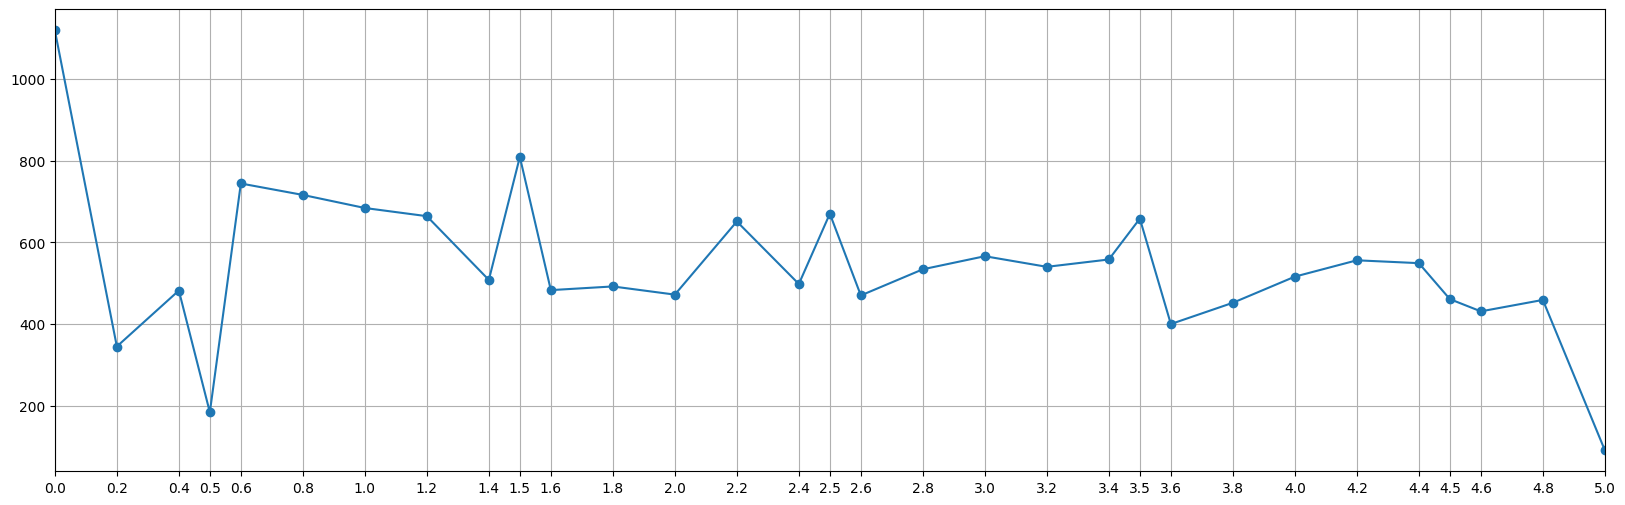

In [48]:
draw_dist(final_v3_df)

In [49]:
# 0.5 구간으로 합치기
section_ser = {'[0, 0.5)':0, '[0.5, 1.0)':0, '[1.0, 1.5)':0, '[1.5, 2.0)':0, '[2.0, 2.5)':0, '[2.5, 3.0)':0, '[3.0, 3.5)':0, '[3.5, 4.0)':0, '[4.0, 4.5)':0, '[4.5, 5.0]':0}
nums = []
for idx in val.index:
    if 0<=idx<0.5:
        section_ser['[0, 0.5)'] += val[idx].item()
    elif 0.5<=idx<1:
        section_ser['[0.5, 1.0)'] += val[idx].item()
    elif 1<=idx<1.5:
        section_ser['[1.0, 1.5)'] += val[idx].item()
    elif 1.5<=idx<2:
        section_ser['[1.5, 2.0)'] += val[idx].item()
    elif 2<=idx<2.5:
        section_ser['[2.0, 2.5)'] += val[idx].item()
    elif 2.5<=idx<3:
        section_ser['[2.5, 3.0)'] += val[idx].item()
    elif 3<=idx<3.5:
        section_ser['[3.0, 3.5)'] += val[idx].item()
    elif 3.5<=idx<4:
        section_ser['[3.5, 4.0)'] += val[idx].item()
    elif 4<=idx<4.5:
        section_ser['[4.0, 4.5)'] += val[idx].item()
    elif 4.5<=idx:
        section_ser['[4.5, 5.0]'] += val[idx].item()

section_ser = pd.Series(section_ser)
section_ser = pd.DataFrame(section_ser)

In [50]:
section_ser

,0
"[0, 0.5)",1946
"[0.5, 1.0)",1644
"[1.0, 1.5)",1856
"[1.5, 2.0)",1784
"[2.0, 2.5)",1621
"[2.5, 3.0)",1674
"[3.0, 3.5)",1664
"[3.5, 4.0)",1510
"[4.0, 4.5)",1621
"[4.5, 5.0]",1442


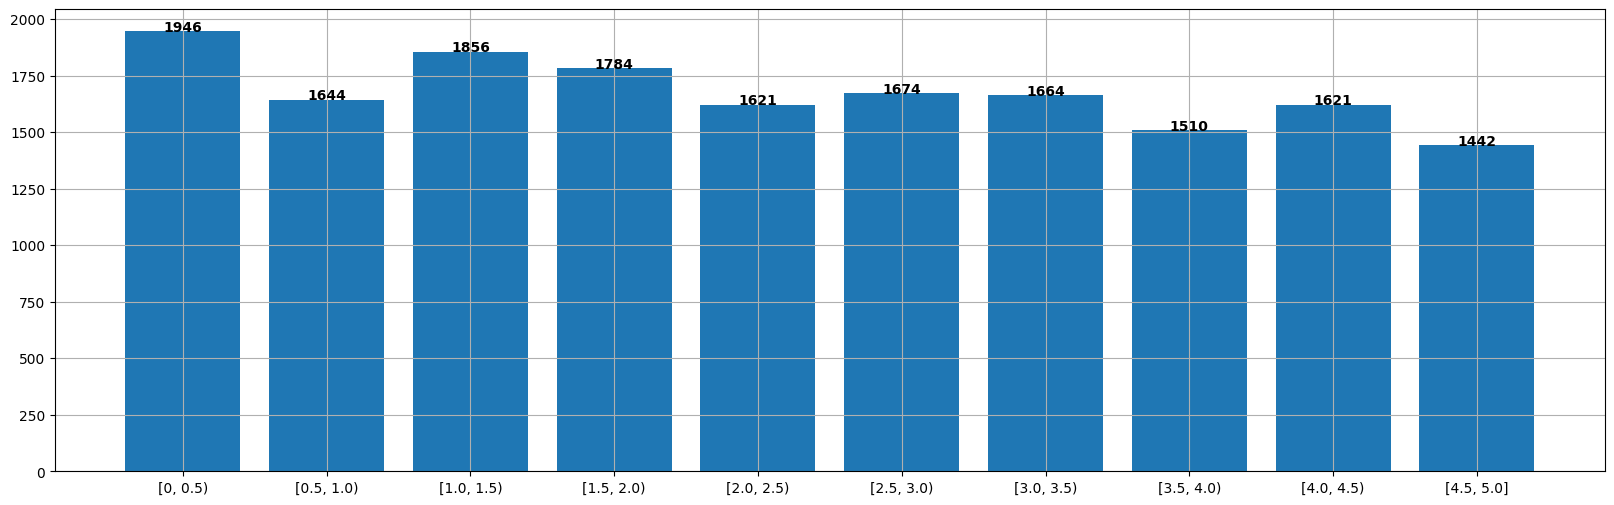

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
axes.bar(section_ser.index, section_ser.values.squeeze())
axes.set_xticks(section_ser.index)
axes.grid()
for idx, value in zip(section_ser.index, section_ser.values.squeeze()):
    axes.text(idx, value, s=value, ha='center', fontweight='bold')
plt.show()